# Text Classification with 20 classes and 10000 examples
    
    Generally CNN and LSTM are known to outperform machine learning algortihms in text classification but when 
    it comes to smaller datasets likes this come machine learning algorithms like SVM and LR does a better job.
    
    Data Loading and preprocessing - Numpy, Pandas, NLTK
    Model testing and classification - Sklearn
    Visualisation and model understanding - Matplotlib and eli5("pip install eli5")

In [181]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

import eli5
from eli5.lime import TextExplainer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Loding the model and spliting it in train-test set for cross validation

In [182]:
data = pd.read_csv('/home/payas/dl_box/data/smartbeings/train_set.txt', sep="\n",header=None)
labels = pd.read_csv('/home/payas/dl_box/data/smartbeings/train_set_labels.txt', sep="\n", header=None)
X_train, X_test, y_train, y_test = train_test_split(data[0],labels[0],test_size=0.1)


# Preprocessing
    
    1. Stop words removal
    2. Stemming
    3. Term frequency–inverse document frequency(Tfidf) Transformation and vectorization  

In [183]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')


In [184]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)
tfidf_transformer =  TfidfVectorizer(stop_words='english',analyzer='char_wb', ngram_range=(1,1))


# Pipelines and model comparision

In [185]:

pipe_lr = make_pipeline(stemmed_count_vect,TfidfTransformer(),LogisticRegression())
pipe_lr_rbm = make_pipeline(stemmed_count_vect,TfidfTransformer(),rbm,LogisticRegression())
pipe_knn = make_pipeline(stemmed_count_vect,TfidfTransformer(),KNeighborsClassifier())
pipe_sgd  = make_pipeline(stemmed_count_vect,TfidfTransformer(),SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))
pipe_cart = make_pipeline(stemmed_count_vect,TfidfTransformer(), DecisionTreeClassifier())
pipe_NB = make_pipeline(stemmed_count_vect,TfidfTransformer(),MultinomialNB())


models = []
models.append(('LR', pipe_lr))
models.append(('KNN', pipe_knn))
models.append(('CART', pipe_cart))
models.append(('NB', pipe_NB))
models.append(('SGD', pipe_sgd))


LR: 0.839100 (0.011404)
KNN: 0.654400 (0.005783)
CART: 0.812900 (0.012804)
NB: 0.740900 (0.059653)
SGD: 0.863700 (0.011263)


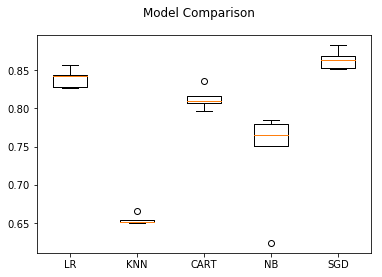

In [186]:
seed = 7
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=seed)
    cv_results = model_selection.cross_val_score(model, data[0], labels[0], cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
 

fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

SGD and LR seems to perform better than Navie Bayes, K-nearest and Decision tress

# Checking individual performance of SVM and LR (F1 Score)

In [187]:
text_clf_svm = Pipeline([('vect', stemmed_count_vect),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, max_iter=5, random_state=42)),])
_ = text_clf_svm.fit(X_train, y_train)


In [188]:
text_clf_lr = Pipeline([('vect', stemmed_count_vect),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', LogisticRegression()),])
_ = text_clf_lr.fit(X_train, y_train)


In [189]:
def print_report(pipe,name):
    
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(name ," Report ----------> \n",report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred))," \n ")


print_report(text_clf_lr, "Logistic Regression")
print_report(text_clf_svm, "SVM")

Logistic Regression  Report ----------> 
              precision    recall  f1-score   support

          1       1.00      0.98      0.99        54
          2       0.95      0.92      0.94        39
          3       0.98      0.96      0.97        46
          4       0.80      0.85      0.82        41
          5       0.96      0.93      0.95        57
          6       1.00      0.89      0.94        54
          7       0.91      0.79      0.85        52
          8       0.51      0.75      0.61        57
          9       0.71      0.83      0.76        47
         10       0.83      0.94      0.88        51
         11       0.93      0.91      0.92        55
         12       0.98      0.90      0.94        58
         13       0.91      0.89      0.90        46
         14       0.93      0.93      0.93        61
         15       0.91      0.89      0.90        55
         16       0.95      0.74      0.83        50
         17       0.92      0.97      0.94        34
   

# Visualization of model's learning using ELI5

In [190]:
te = TextExplainer(random_state=42)
te.fit(data[:1].to_string(), text_clf_lr.predict_proba)
te.show_prediction()

In [191]:
te.fit(data[-2:].to_string(), text_clf_lr.predict_proba)
te.show_prediction()

# Grid search for hyperparameter tuning

In [192]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2),(1,3)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train,y_train)
print(gs_clf_svm.best_score_,gs_clf_svm.best_params_)

0.8701111111111111 {'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


# Ensembling Models

In [193]:
pipe_lr = make_pipeline(stemmed_count_vect,TfidfTransformer(),LogisticRegression())
pipe_sgd  = make_pipeline(stemmed_count_vect,TfidfTransformer(),SGDClassifier(loss='hinge', penalty='l2',alpha=0.001, max_iter=5, random_state=42))
pipe_cart = make_pipeline(stemmed_count_vect,TfidfTransformer(), DecisionTreeClassifier())

ensemble_models = []
ensemble_models.append(('LR', pipe_lr))
#ensemble_models.append(('CART', pipe_cart))
ensemble_models.append(('SGD', pipe_sgd))

In [194]:
ensemble = VotingClassifier(ensemble_models)
results = model_selection.cross_val_score(ensemble, data[0], labels[0].values, cv=kfold)
print(results.mean())

0.8493


In [195]:
ensemble.fit(data[0],labels[0])
test_results = ensemble.predict(data_test[0])
print(test_results[-5:])

[20 20 20 20 20]


# Submission

In [196]:
data_test = pd.read_csv('/home/payas/dl_box/data/smartbeings/test_sentences.txt', sep="\n",header=None)

In [197]:
text_clf_svm.fit(data[0],labels[0])
test_results_final = text_clf_svm.predict(data_test[0])

In [198]:
submission = open('/home/payas/dl_box/data/smartbeings/submission.txt', 'w')
for item in test_results_final:
  submission.write("%s\n" % item)